In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [13]:
housing = datasets.load_boston()
X = pd.DataFrame(housing.data, columns = housing.feature_names)
X.head()
y = housing.target

In [14]:
housing.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

CRIM - уровень преступности на душу населения

ZN - доля земель под жилую застройку, зонированных под участки площадью более 25 000 кв. футов

INDUS - доля акров, не связанных с розничной торговлей, на город

CHAS - фиктивная переменная реки Чарльз (= 1, если участок ограничивает реку; 0 в противном случае)

NOX - уровень закиси азота (частей на 10 миллионов)

RM - среднее количество комнат в доме.

AGE - доля частных домов, построенных до 1940 года.

DIS - взвешенные расстояния до пяти бостонских центров занятости

RAD - индекс доступности радиальных автомагистралей.

TAX - ставка налога на недвижимость 

PTRATIO - соотношение числа учащихся и преподавателей в районе 

B - 1000 (Bk - 0,63)², где Bk - доля лиц афроамериканского происхождения по городам.

LSTAT - процент населения с более низким статусом

Целевая переменная - средняя стоимость домов в тысячах долларов

Посмотрим, как коррелируют признаки друг с другом и с целевой переменной. Видим, что есть нелинейные зависимости.

In [15]:
X2 = X.copy() #Делаем DataFrame X2, чтобы добавить в него целевую переменную и выводить корреляции вместе с ней
X2['y'] = y

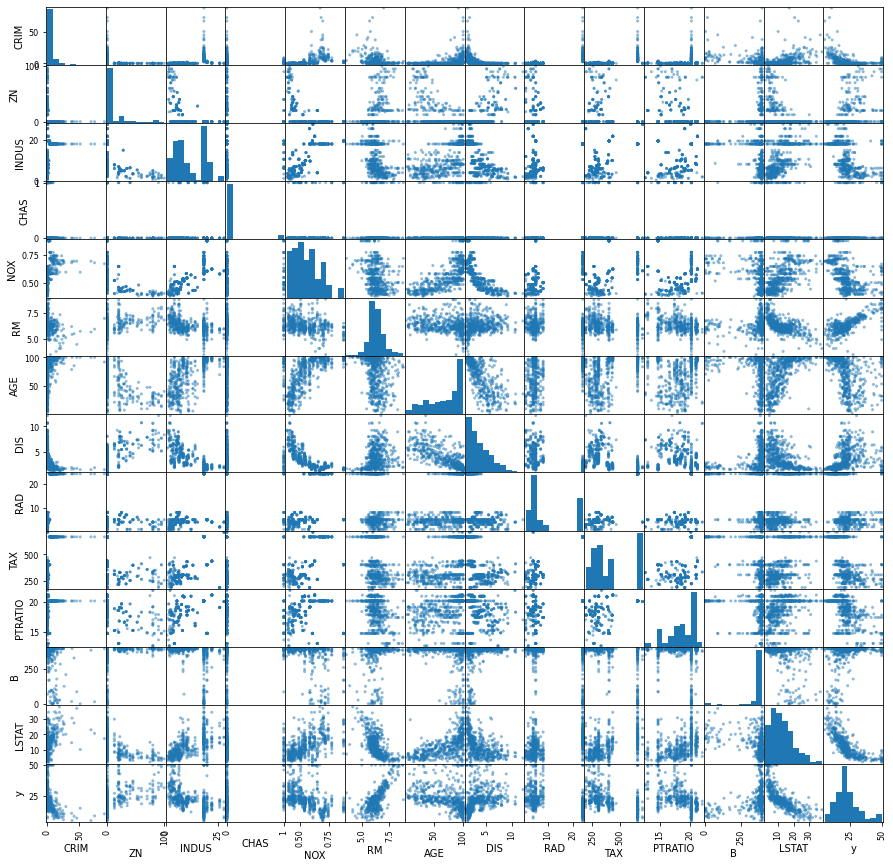

In [16]:
scatter = pd.plotting.scatter_matrix(X2, alpha=0.5, figsize = (15,15))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

Вся тренировка, настройка, оценка будет проходить на X_train, y_train. X_test, y_test - для финальной оценки

Дополнительно к имеющимся признакам сгенерируем полиномиальные признаки. В качестве модели возьмем линейную модель с L2 регуляризацией. В оценщике необходимо задать параметр max_iter = 50000, tol=0.01 - увеличить количество эпох, чтобы подойти ближе к точки минимума.

Используем конвейер, не забываем про масштабирование.

Подобрать параметры - степень полинома 1-2, коэффициент регуляризации модели - степени 10 от -3 до 3.
Кросс-валидация на 5ти блоках, scoring = 'r2'

In [18]:
clfr=[Lasso(max_iter = 50000, tol=0.01),Ridge(max_iter = 50000, tol=0.01)]

scaler = StandardScaler()
pipe = Pipeline([('poly',PolynomialFeatures()),('scaler', StandardScaler()), ('Model', clfr[0] )])

#pipe.fit(X_train, y_train)
#y_pred=pipe.predict(X_test)

Cs=[0.001,0.01,0.1,1,10,100,1000]
D=[1,2]
print(pipe.get_params())

param_grid = {'Model__alpha':Cs,'poly__degree':D,'Model':clfr}

grid_search = GridSearchCV(pipe,param_grid,cv=5,scoring = 'r2')
print(grid_search.fit(X_train,y_train))

print(grid_search.best_params_ )
print(grid_search.best_estimator_)




{'memory': None, 'steps': [('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('Model', Lasso(max_iter=50000, tol=0.01))], 'verbose': False, 'poly': PolynomialFeatures(), 'scaler': StandardScaler(), 'Model': Lasso(max_iter=50000, tol=0.01), 'poly__degree': 2, 'poly__include_bias': True, 'poly__interaction_only': False, 'poly__order': 'C', 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'Model__alpha': 1.0, 'Model__copy_X': True, 'Model__fit_intercept': True, 'Model__max_iter': 50000, 'Model__normalize': False, 'Model__positive': False, 'Model__precompute': False, 'Model__random_state': None, 'Model__selection': 'cyclic', 'Model__tol': 0.01, 'Model__warm_start': False}
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('Model',
                                        Lasso(alpha=0.01, max_iter=50000,
   

Какие параметры оказались лучшими?
В качестве оценщика можно использовать grid_search.best_estimator_ 
Сколько получилось признаков после применения полиномизации? (у объекта PolynomialFeatures свойство .n_output_features_)
После регуляризации L2 сколько признаков значимо (имеют абсолютное значение больше единицы) Hint. sum([True,False,False]) = 1

In [19]:
print(grid_search.best_params_ )
print(grid_search.best_estimator_)



{'Model': Lasso(alpha=0.01, max_iter=50000, tol=0.01), 'Model__alpha': 0.01, 'poly__degree': 2}
Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('Model', Lasso(alpha=0.01, max_iter=50000, tol=0.01))])


In [20]:
grid_search.best_estimator_.steps[0][1].n_output_features_#столько признаков получилось


105

In [21]:
W=grid_search.best_estimator_.steps[2][1].coef_
c1=np.abs(W)> 1 #признаков значимо (имеют абсолютное значение больше единицы)
print(c1.sum())

26


Оценить качество на отложенной выборке. В качестве оценщика можно взять grid_search.best_estimator_.
Вывести RMSE, r2

In [22]:

y_pred_train = grid_search.best_estimator_.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

y_pred_test = grid_search.best_estimator_.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)


rmse1 = (np.sqrt(mean_squared_error(y_train, y_pred_train)))

rmse2 = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R2_score (train): ', r2_score_train)
print("RMSE(train): ", rmse1)

R2_score (train):  0.9096774607504028
RMSE(train):  2.823918272433098


Проверить остатки на гомоскедастичность и нормальное распределение

In [23]:
print('R2_score (test): ', r2_score_test)
print("RMSE(test): ", rmse2)

R2_score (test):  0.7485151993134882
RMSE(test):  3.9404518198084153


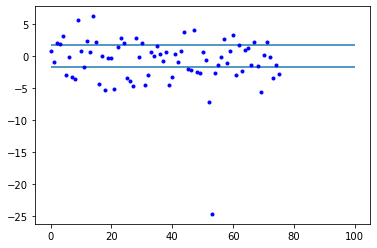

In [24]:

residuals = y_test - y_pred_test
plt.plot(residuals, "b.")
plt.hlines(-1.7, 0, 100)
plt.hlines(1.7, 0, 100)


In [25]:
from pandas import DataFrame
df = DataFrame(residuals)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

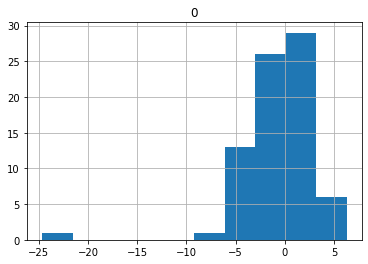

In [26]:
df.hist(bins=10)

<AxesSubplot:ylabel='Density'>

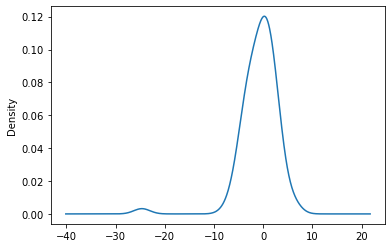

In [27]:
df.plot(kind='kde', legend = False) 